# Observed Markov Models for new pipeline

Translated from R as written here: https://github.com/prio-data/viewsforecasting/tree/main/Tools/new_markov

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pickle as pkl

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# set path
import sys, os
sys.path.append(os.path.abspath(".."))

from src import markov_model
importlib.reload(markov_model)
from src.markov_model import MarkovModel

## 1. Import test dataset(s)

In [2]:
data = pd.read_parquet("../data/testdataset.parquet")

Decide on feature sets:

In [3]:
all_features = data.columns

state_features = all_features.drop(
    ["gleditsch_ward", "ged_sb", "ln_ged_sb_dep", 
     "ln_ged_sb", "ln_ged_sb_tlag_1"]
).tolist()

fatalities_features = all_features.drop(
    ["gleditsch_ward", "ged_sb", "ln_ged_sb_dep"]
).tolist()

## 2. Initialize and fit Markov models:

Model parameters:

In [4]:
random_seed = 42
partitioner_dict = {"train":(121,408),"test":(409,456)}

Initialize Markov model using direct method:

In [5]:
mm_direct = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="direct",
    random_state=random_seed
)

And using transition matrix method:

In [6]:
mm_transition = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="transition",
    random_state=random_seed
)

Fit for with direct method. Expected run time is around 15 minutes.

In [10]:
mm_direct.fit(
    data=data,
    steps=range(1, 37),
    target="ln_ged_sb",
    markov_target="ged_sb",
    state_features=state_features,
    fatalities_features=fatalities_features
)

Fitting Random Forest Classifier for state: war and step: 36                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


And fit with transition matrix method. Expected run time is around 30 seconds.

In [7]:
mm_transition.fit(
    data=data,
    steps=range(1, 37),
    target="ln_ged_sb",
    markov_target="ged_sb",
    state_features=state_features,
    fatalities_features=fatalities_features
)

Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


In [8]:
mm_transition._fatalities_features

['vdem_v2x_edcomp_thick',
 'vdem_v2x_egal',
 'vdem_v2x_execorr',
 'vdem_v2x_frassoc_thick',
 'vdem_v2x_gencs',
 'vdem_v2x_gender',
 'vdem_v2x_genpp',
 'vdem_v2x_horacc',
 'vdem_v2x_neopat',
 'vdem_v2x_pubcorr',
 'vdem_v2x_rule',
 'vdem_v2x_veracc',
 'vdem_v2x_ex_military',
 'vdem_v2x_ex_party',
 'vdem_v2x_freexp',
 'vdem_v2xcl_acjst',
 'vdem_v2xcl_dmove',
 'vdem_v2xcl_prpty',
 'vdem_v2xcl_rol',
 'vdem_v2xcl_slave',
 'vdem_v2xdd_dd',
 'vdem_v2xdl_delib',
 'vdem_v2xeg_eqdr',
 'vdem_v2xeg_eqprotec',
 'vdem_v2xel_frefair',
 'vdem_v2xel_regelec',
 'vdem_v2xme_altinf',
 'vdem_v2xnp_client',
 'vdem_v2xnp_regcorr',
 'vdem_v2xpe_exlecon',
 'vdem_v2xpe_exlpol',
 'vdem_v2xpe_exlgeo',
 'vdem_v2xpe_exlgender',
 'vdem_v2xpe_exlsocgr',
 'vdem_v2xps_party',
 'vdem_v2xcs_ccsi',
 'vdem_v2xnp_pres',
 'vdem_v2xeg_eqaccess',
 'vdem_v2x_diagacc',
 'vdem_v2clrgunev',
 'wdi_sp_pop_totl',
 'ln_ged_sb_tlag_1',
 'ln_ged_sb_tlag_2',
 'ln_ged_sb_tlag_3',
 'ln_ged_sb_tlag_4',
 'ln_ged_sb_tlag_5',
 'ln_ged_sb_tlag_6

## 3. Make predictions

Now make predictions with both the direct method and transition matrix method models:

In [11]:
predictions_direct = mm_direct.predict(
    data=data,
    steps=range(1,37),
)

Predicting step 36 using direct method.                    
Finished predicting for all steps.


In [9]:
predictions_transition = mm_transition.predict(
    data=data,
    steps=range(1,37),
)

Predicting step 36 using transition method.                    
Finished predicting for all steps.


And now to compare with the actuals, we first merge the predictions from both method together:

In [12]:
# merge predictions direct with predictions transition on index
predictions_merged = predictions_direct.merge(
    predictions_transition,
    left_index=True,
    right_index=True,
    suffixes=('_direct', '_transition')
)

Save this to pickle to avoid having to re-run the above steps:

In [30]:
# save predictions_merged to pickle
with open("../data/predictions_merged_log_updated.pkl", "wb") as f:
    pkl.dump(predictions_merged, f)

And reopen if necessary:

In [16]:
with open("../data/predictions_merged.pkl", "rb") as f:
    predictions_merged = pkl.load(f)

And then merge with the actuals:

In [13]:
actuals = data.rename_axis(index={"month_id": "target_month_id"})

# merge with actuals from data
predictions_merged = predictions_merged.merge(
    actuals[["ln_ged_sb"]],
    left_index=True,
    right_index=True
)

And then we can make a basic MSE plot over steps ahead:

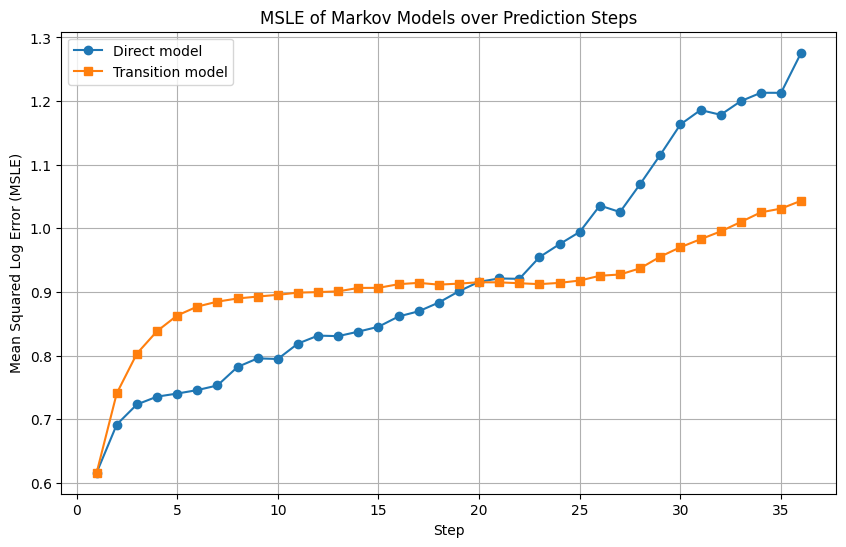

In [16]:
df = predictions_merged.copy()
df.dropna(inplace=True)


# define true values
y_true = df["ln_ged_sb"].values


direct_rmsle = []
transition_rmsle = []

for step in range(1, 37):

    direct_rmse_val = mean_squared_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"])
    transition_rmse_val = mean_squared_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"])

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Direct model")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Transition model")
plt.xlabel("Step")
plt.ylabel("Mean Squared Log Error (MSLE)")
plt.title("MSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()


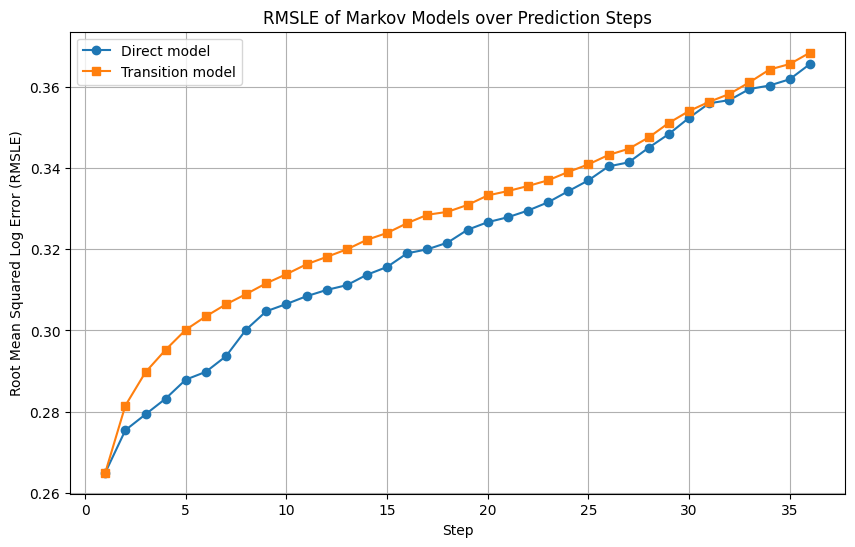

In [15]:
direct_rmsle = []
transition_rmsle = []

for step in range(1, 37):
    
    direct_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"]))
    transition_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"]))

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Direct model")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Transition model")
plt.xlabel("Step")
plt.ylabel("Root Mean Squared Log Error (RMSLE)")
plt.title("RMSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()